A single model without WSIs.
## Preparing libraries

In [1]:
! pip install albumentations
#! pip install pretrainedmodels
! pip install pytorchcv

In [2]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time 
import tqdm
import random
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2

import albumentations
from albumentations import pytorch as AT
#import pretrainedmodels

import scipy.special

from pytorchcv.model_provider import get_model as ptcv_get_model

cudnn.benchmark = True

In [3]:
SEED = 323
base_dir = 'input/'
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

## Preparing data & Simple EDA

In [4]:
files = os.listdir(base_dir+"train")
files_noext = [i.split(".")[0] for i in files]

In [5]:
labels = pd.read_csv(base_dir+'train_labels.csv')
labels = labels.loc[labels["id"].isin(files_noext)]
img_class_dict = {k:v for k, v in zip(labels.id, labels.label)}

In [6]:
print(len(os.listdir(base_dir+"train")))

784


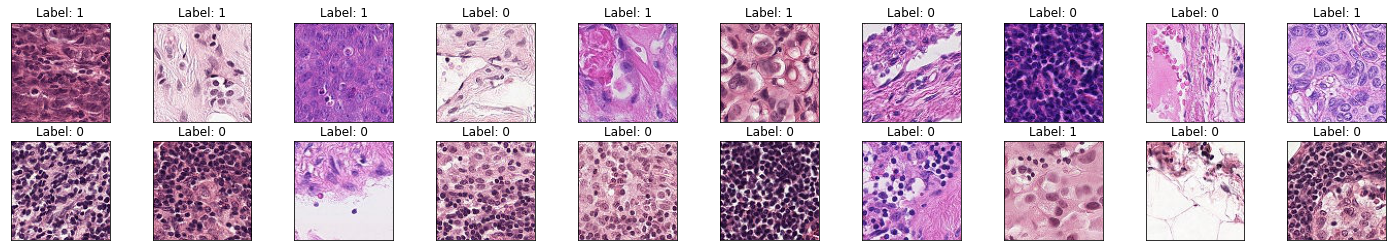

In [7]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [8]:
labels.label.value_counts()

0    465
1    319
Name: label, dtype: int64

## Model

In [9]:
class CancerDataset(Dataset):
    def __init__(self, dataset=None, datafolder=None, datatype='train', transform=transforms.Compose([transforms.CenterCrop(64),transforms.ToTensor()]), labels_dict={}):
        self.dataset = dataset
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    @classmethod
    def attack(cls, dataset, transform=transforms.Compose([transforms.CenterCrop(64),transforms.ToTensor()])):
        return cls(dataset, None, 'attack', transform)
        
    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        if self.datatype != 'attack':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            img = cv2.imread(img_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image = self.transform(image=img)
            image = image['image']

            img_name_short = self.image_files_list[idx].split('.')[0]

            if self.datatype == 'train':
                label = self.labels_dict[img_name_short]
            else:
                label = 0
            return image, label
        else:
            return self.dataset[idx], 0

In [10]:
data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2), albumentations.Sharpen(), albumentations.Emboss(), 
        albumentations.RandomBrightness(), albumentations.RandomContrast(),
        albumentations.JpegCompression(), albumentations.Blur(), albumentations.GaussNoise()], p=0.5), 
    albumentations.HueSaturationValue(p=0.5), 
    albumentations.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

data_transforms_tta0 = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

data_transforms_tta1 = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.RandomRotate90(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

data_transforms_tta2 = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Transpose(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

data_transforms_tta3 = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Flip(p=1),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensorV2()
    ])

dataset = CancerDataset(datafolder=base_dir+'train/', datatype='test', transform=data_transforms_test, labels_dict=img_class_dict)
batch_size = 16
num_workers = 0
# prepare data loaders (combine dataset and sampler)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

/home/simonl/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/simonl/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/simonl/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [11]:
model_conv = ptcv_get_model("cbam_resnet50", pretrained=True)
#model_conv = ptcv_get_model("bam_resnet50", pretrained=True)

#model_conv = pretrainedmodels.se_resnext101_32x4d()
model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=1, bias=True))

## Inference

In [12]:
model_conv.eval()

CbamResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): CbamResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [13]:
saved_dict = torch.load('model.pt', map_location=torch.device('cpu'))
model_conv.load_state_dict(saved_dict)

<All keys matched successfully>

In [14]:
import math
sigmoid = lambda x: 1 / (1 + math.exp(-x))

In [19]:
for batch_i, (data, target) in enumerate(dataloader):
    print(data[0])

tensor([[[ 0.7077,  0.7077,  0.6906,  ...,  1.6495,  1.8208,  1.8893],
         [ 0.6906,  0.6906,  0.7077,  ...,  1.7009,  1.8379,  1.8722],
         [ 0.6563,  0.6906,  0.7419,  ...,  1.8722,  1.8379,  1.8208],
         ...,
         [-0.3027, -0.1486,  0.3309,  ...,  1.2214,  1.3755,  1.4098],
         [-0.0801, -0.0629,  0.0398,  ...,  1.0331,  0.9132,  0.8789],
         [-0.0116, -0.0287, -0.0629,  ...,  0.9646,  0.7762,  0.7077]],

        [[-0.3375, -0.3550, -0.4426,  ...,  0.7129,  0.8880,  0.9580],
         [-0.3375, -0.3550, -0.4076,  ...,  0.7654,  0.8880,  0.9405],
         [-0.3375, -0.3375, -0.3200,  ...,  0.9055,  0.8880,  0.8704],
         ...,
         [-1.4580, -1.2829, -0.7402,  ...,  0.2402,  0.3978,  0.4503],
         [-1.2304, -1.1779, -1.0553,  ..., -0.0049, -0.1099, -0.1450],
         [-1.1429, -1.1429, -1.1429,  ..., -0.0924, -0.2850, -0.3375]],

        [[ 0.2522,  0.2348,  0.1999,  ...,  1.3154,  1.4897,  1.5420],
         [ 0.2696,  0.2696,  0.2348,  ...,  1

In [123]:
preds = []
for batch_i, (data, target) in enumerate(dataloader):
    #data, target = data.cuda(), target.cuda()
    output = model_conv(data).detach()
    pr = output[:,0].numpy()
    #pr = output[:,0]#.cpu().numpy()
    for i in pr:
        preds.append(sigmoid(i))
    if batch_i == 10:
        break

In [124]:
preds_df = pd.DataFrame({'imgs': dataset.image_files_list[:len(preds)], 'preds': preds})
preds_df['imgs'] = preds_df['imgs'].apply(lambda x: x.split('.')[0])
preds_df["labels"] = preds_df["imgs"].apply(lambda x: img_class_dict[x])

In [125]:
preds_df

,imgs,preds,labels
0,f6ced0923558d4f7dacbb94512173786e6e2d22c,0.034030,0
1,f63d00dadcbce3d3853ebd8e55b7357ed7efe288,0.039681,0
2,f628ddbcd6103680467f2ed0ec913f45813364de,0.011458,0
3,f672bba21067f4176d5d634a84285036716d0fbd,0.999678,1
4,f66033e4573bd0bf783ad9846379637c4653afbf,0.018283,0
...,...,...,...
171,f628a7f305147ab4c67e3a7e37afd5f4717ec166,0.207841,0
172,f6a4e578f612b1e135fd19f59cc5eed124939d12,0.946127,1
173,f6dfdc58d28b6cb745865745ad04a34085e8a696,0.010241,0
174,f621b8cf781431031e5eef1087e553e2c5e0acf5,0.038761,0


In [126]:
print("Finished")

Finished
